![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [3]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape)

Number of data points: (404290, 6)


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

is_duplicate
0    255027
1    149263
Name: id, dtype: int64


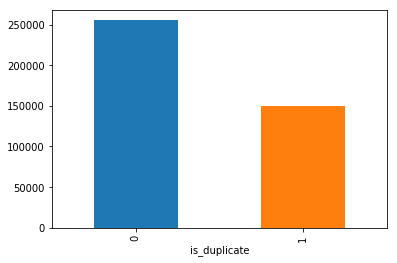

In [10]:
count_ = df.groupby("is_duplicate")['id'].count()
print(count_)
count_.plot.bar()

In [11]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [20]:
print('~> Question pairs are not Similar (is_duplicate = 0):   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):   63.08%

~> Question pairs are Similar (is_duplicate = 1):   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [22]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



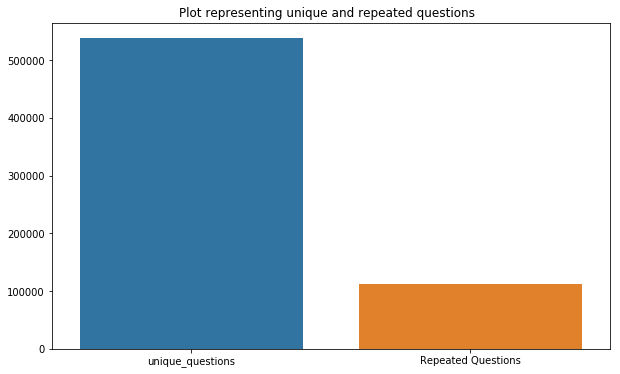

In [23]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [24]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



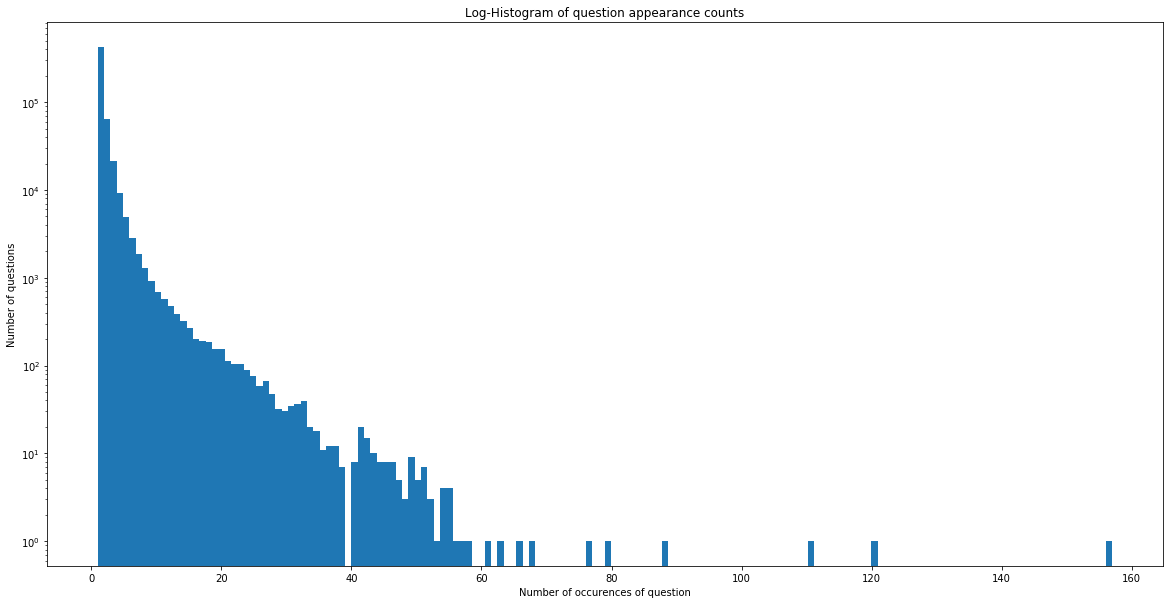

In [26]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [28]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [30]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [32]:
nan_rows = df[df.isnull().any(1)]

<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [34]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [35]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

/home/ajay/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



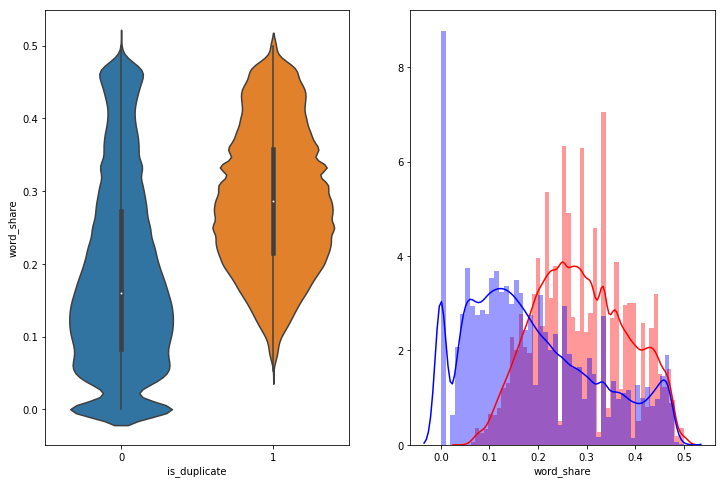

In [36]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

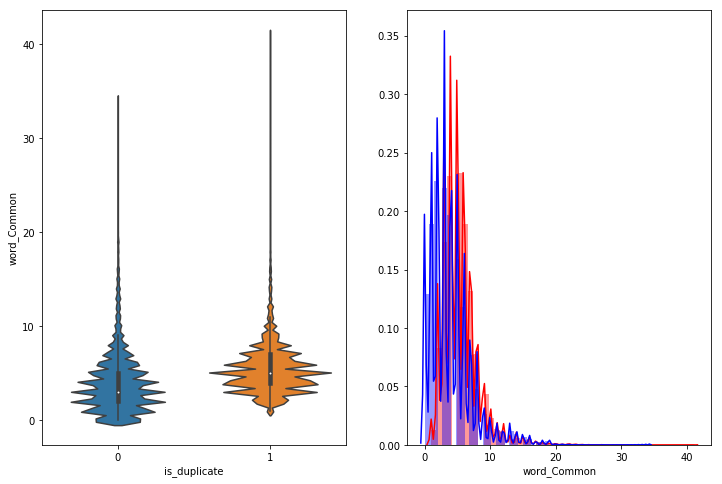

In [37]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

### 1.2.1 : EDA: Advanced Feature Extraction.


In [38]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [39]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [40]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [31]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [41]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [42]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [43]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [44]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [45]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


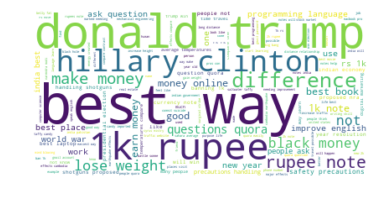

In [46]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


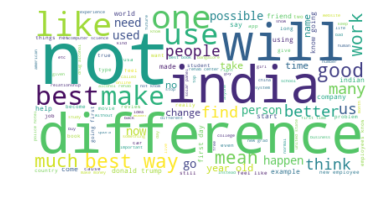

In [47]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

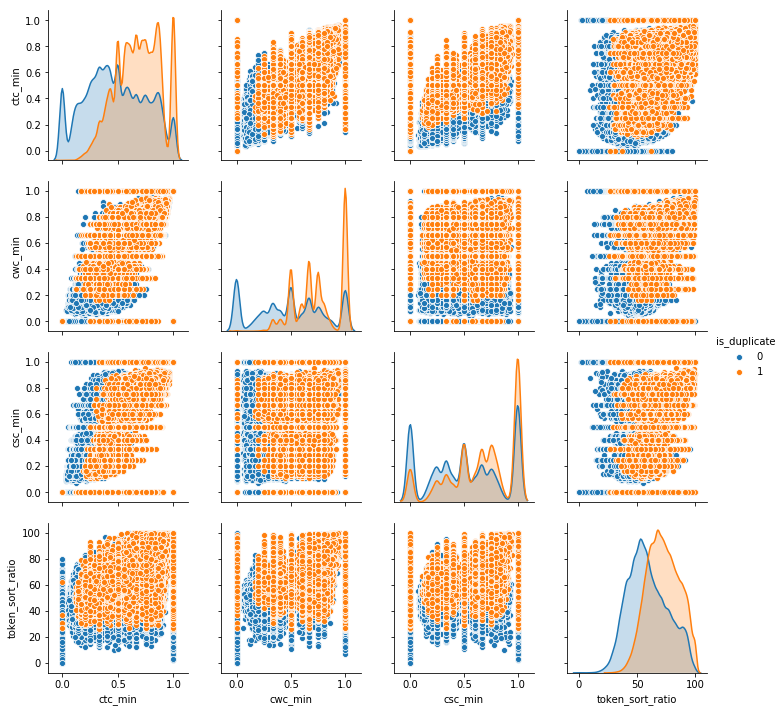

In [48]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

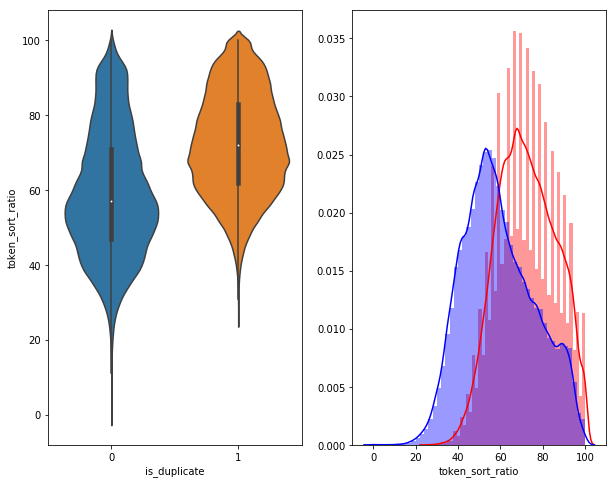

In [49]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

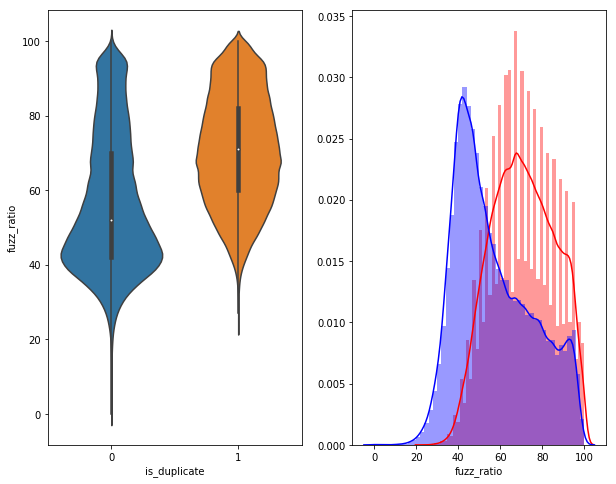

In [50]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [51]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [52]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.025s...
[t-SNE] Computed neighbors for 5000 samples in 0.395s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.413s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 2.612s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 1.819s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 1.867s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 2.182s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

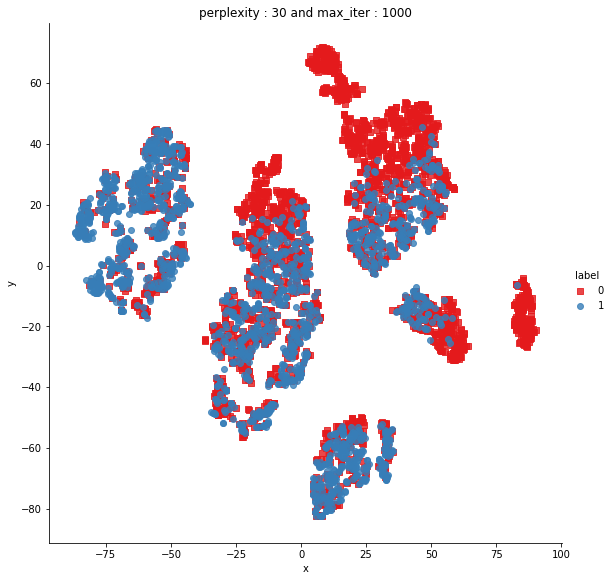

In [53]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [54]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 0.468s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.371s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 13.330s)
[t-SNE] Iteration 100: error = 69.1127167, gradient norm = 0.0036756 (50 iterations in 7.724s)
[t-SNE] Iteration 150: error = 67.6178818, gradient norm = 0.0017629 (50 iterations in 6.682s)
[t-SNE] Iteration 200: error = 67.0571747, gradient norm = 0.0011826 (50 iterations in 6.465s)
[t-SNE] Iteration 250: error = 66.7298050, gradient norm = 0.000852

In [56]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [23]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
#nlp = spacy.load('en_core_web_sm')

import en_core_web_sm
nlp = en_core_web_sm.load()

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████| 404290/404290 [1:19:48<00:00, 84.43it/s]


In [24]:
print(type(vecs1))
print(len(vecs1))
np.array(vecs1).shape

<class 'list'>
404290


(404290, 96)

In [27]:
import pickle
with open('vecs1', 'wb') as fp:
    pickle.dump(vecs1, fp)

In [7]:
import pickle
with open ('vecs1', 'rb') as fp:
    vecs1 = pickle.load(fp)
    
    
print(type(vecs1))
print(len(vecs1))
np.array(vecs1).shape

<class 'list'>
404290


(404290, 96)

In [9]:
import en_core_web_sm
nlp = en_core_web_sm.load()

vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:12:32<00:00, 92.90it/s]


In [10]:
print(type(vecs2))
print(len(vecs2))
np.array(vecs2).shape

<class 'list'>
404290


(404290, 96)

In [11]:
import pickle
with open('vecs2', 'wb') as fp:
    pickle.dump(vecs2, fp)

In [8]:
with open ('vecs2', 'rb') as fp:
    vecs2 = pickle.load(fp)
    
print(type(vecs2))
print(len(vecs2))
np.array(vecs2).shape

<class 'list'>
404290


(404290, 96)

In [10]:
df['q1_feats_m'] = vecs1
df['q2_feats_m'] = vecs2

vecs1=[]
vecs2=[]
#lineList = [line.rstrip('\n') for line in open(fileName)]

In [11]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [12]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [13]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [14]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [15]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,211.129874,-144.683054,-68.811249,-153.662109,-89.931611,2.311274,136.743697,50.449099,-64.150947,56.627538,...,33.176600,-102.487000,144.595707,50.614258,-21.385909,36.385574,-70.999801,4.141482,-131.379516,71.884578
1,144.124648,-114.012485,-111.716660,-104.885020,-88.238451,16.441811,58.238055,102.095074,6.026957,178.498576,...,67.386258,22.131793,40.210763,0.254038,98.600218,-36.436028,-123.609746,71.788323,-15.374581,-10.503989
2,81.757864,-142.184514,0.559871,-104.660074,-84.156632,22.515128,115.521672,50.436953,-111.740921,51.713283,...,61.731843,-49.822509,107.080585,-11.431460,-40.667738,-26.771835,-12.482051,1.764692,-100.330469,148.061182
3,-126.651898,-59.747152,-67.763228,-138.114753,-101.038727,88.148521,-22.912262,85.941433,27.784232,50.810635,...,117.847438,-13.044566,-1.643150,78.158391,23.748121,12.946001,-8.807328,123.360072,64.057073,-24.943291
4,299.444034,-188.631994,-22.946243,-273.683356,-188.480359,107.123026,174.946275,-72.042302,-98.290455,137.440024,...,62.256722,-173.503653,249.320188,27.972500,-26.665015,-28.469178,-62.335420,2.738913,-120.762608,111.779830


In [16]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,151.268531,-127.013174,-31.546291,-142.905781,-97.249108,9.485730,106.682230,36.754153,-36.541901,53.162223,...,28.763412,-108.306629,131.115580,42.530930,-14.726201,15.763613,-59.729559,-9.563372,-99.812548,57.643640
1,152.023074,-44.955356,-103.559248,-128.467540,-118.567592,44.577929,137.906209,26.984688,-78.328355,86.576884,...,117.588041,5.239813,56.622434,92.054098,141.063333,-30.466213,-25.418968,87.120071,-23.594480,7.936897
2,4.930252,-29.029568,-117.808777,-98.332260,-19.064157,-9.867785,141.808178,91.269573,50.727237,12.816821,...,128.699924,17.433380,58.203355,88.642943,-84.962801,71.462319,-10.853905,-59.501689,-99.425307,95.334793
3,-6.951958,-44.951737,-17.343058,-61.444457,-7.469162,16.941943,95.049226,-2.631614,-13.050928,-28.038384,...,70.475263,-31.174242,86.080270,49.967749,25.750421,-27.612360,24.050787,-3.504155,-46.115806,56.242263
4,96.174529,-71.613957,21.584909,-92.742441,-106.643132,10.646803,92.190119,-40.565991,-34.739529,56.340503,...,18.852802,-70.416546,87.693583,38.386026,-14.003126,-12.975115,46.318854,-25.159628,-53.098672,-2.351899


In [17]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [18]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [2]:
#Last run
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [ ]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [ ]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [0]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [ ]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [ ]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [0]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.199996000079998,0.166663888935184,0.0,0.0,0.14285510206997,0.0999990000099999,0.0,0.0,3.0,8.5,...,-0.452613651752472,15.652570605278,6.08213365077972,-11.8397651314735,13.1632919311523,-2.98961134254932,-22.7671056985855,-0.55659094452858,16.7820047736168,20.3098403215408
2,0.399992000159997,0.399992000159997,0.499987500312492,0.499987500312492,0.444439506227709,0.444439506227709,0.0,0.0,0.0,9.0,...,-7.29706252366304,8.17464561760426,11.8678730130196,-0.180742904543877,-7.7285645082593,-1.18125408887863,-10.2087883651257,1.95615618489683,5.9711550520733,-0.634018301963806
3,0.833319444675922,0.714275510349852,0.999983333611106,0.857130612419823,0.687495703151855,0.687495703151855,0.0,1.0,0.0,16.0,...,10.6274425089359,8.40339290164411,14.16905092448,-14.7492953687906,13.0176268517971,15.6888161092065,-26.4774019122124,24.7521114945412,14.29726113379,0.945210464298725
4,0.0,0.0,0.599988000239995,0.499991666805553,0.249997916684028,0.230767455634957,0.0,0.0,1.0,12.5,...,9.43481918051839,47.0162477493286,6.11483122035861,-9.12068559974432,-3.70159254875034,-6.60001696646214,-26.1024898421019,13.254497602582,10.0541534200311,-6.71233975887299
5,0.749981250468738,0.749981250468738,0.499987500312492,0.499987500312492,0.624992187597655,0.624992187597655,1.0,0.0,0.0,8.0,...,-0.158434137701988,13.7061135396361,6.35377380251884,-7.79693192709237,7.42785215843469,0.602214589715004,-17.1489275898784,-1.66515278816223,4.06413406133652,3.87387558817863


In [0]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [ ]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>


In [ ]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [0]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 794)
Number of data points in test data : (30000, 794)


In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6324857142857143 Class 1:  0.36751428571428574
---------- Distribution of output variable in train data ----------
Class 0:  0.3675 Class 1:  0.3675


In [103]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.887242646958


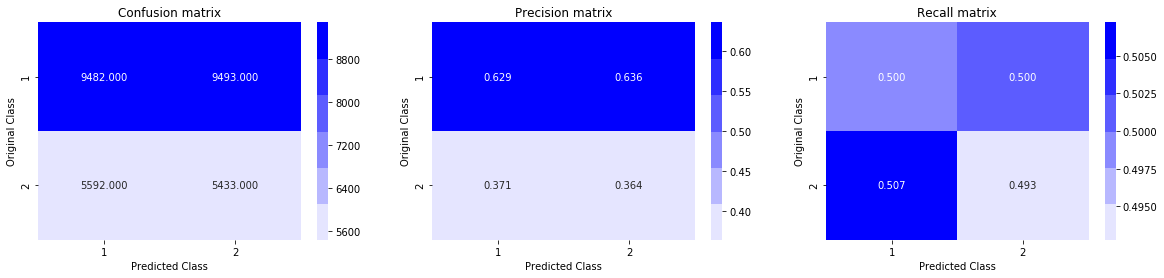

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.592800211149
For values of alpha =  0.0001 The log loss is: 0.532351700629
For values of alpha =  0.001 The log loss is: 0.527562275995
For values of alpha =  0.01 The log loss is: 0.534535408885
For values of alpha =  0.1 The log loss is: 0.525117052926
For values of alpha =  1 The log loss is: 0.520035530431
For values of alpha =  10 The log loss is: 0.521097925307


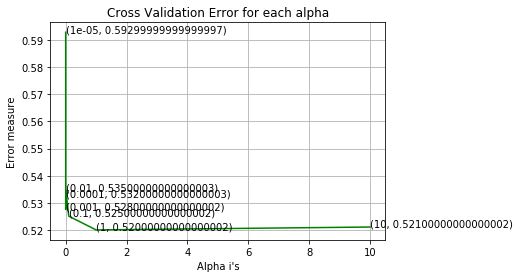

For values of best alpha =  1 The train log loss is: 0.513842874233
For values of best alpha =  1 The test log loss is: 0.520035530431
Total number of data points : 30000


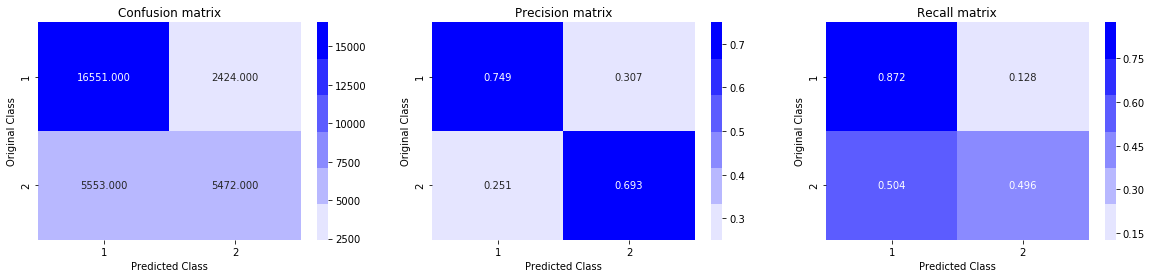

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [108]:
print(X_train.shape)

(70000, 21)


For values of alpha =  1e-05 The log loss is: 0.657611721261
For values of alpha =  0.0001 The log loss is: 0.489669093534
For values of alpha =  0.001 The log loss is: 0.521829068562
For values of alpha =  0.01 The log loss is: 0.566295616914
For values of alpha =  0.1 The log loss is: 0.599957866217
For values of alpha =  1 The log loss is: 0.635059427016
For values of alpha =  10 The log loss is: 0.654159467907


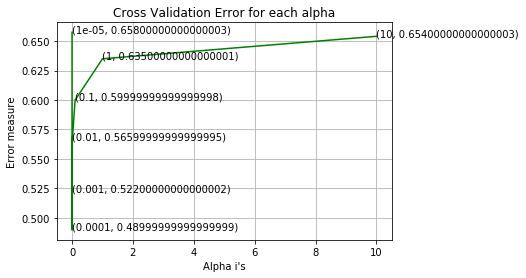

For values of best alpha =  0.0001 The train log loss is: 0.478054677285
For values of best alpha =  0.0001 The test log loss is: 0.489669093534
Total number of data points : 30000


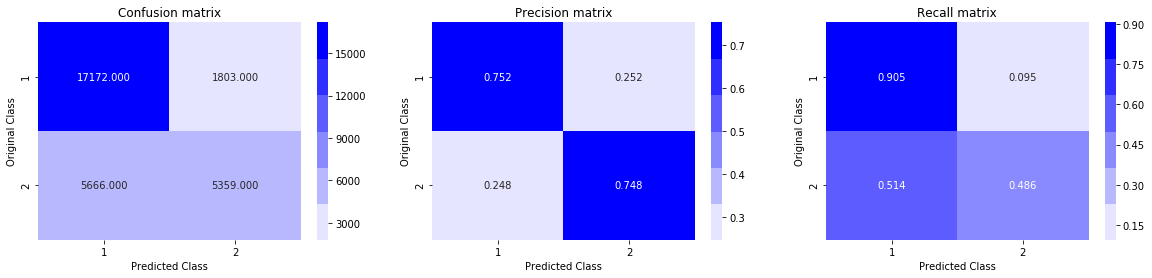

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

<h2> 4.6 XGBoost </h2>

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684819	valid-logloss:0.684845
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61583	valid-logloss:0.616104
[20]	train-logloss:0.564616	valid-logloss:0.565273
[30]	train-logloss:0.525758	valid-logloss:0.52679
[40]	train-logloss:0.496661	valid-logloss:0.498021
[50]	train-logloss:0.473563	valid-logloss:0.475182
[60]	train-logloss:0.455315	valid-logloss:0.457186
[70]	train-logloss:0.440442	valid-logloss:0.442482
[80]	train-logloss:0.428424	valid-logloss:0.430795
[90]	train-logloss:0.418803	valid-logloss:0.421447
[100]	train-logloss:0.41069	valid-logloss:0.413583
[110]	train-logloss:0.403831	valid-logloss:0.40693
[120]	train-logloss:0.398076	valid-logloss:0.401402
[130]	train-logloss:0.393305	valid-logloss:0.396851
[140]	train-logloss:0.38913	valid-logloss:0.392952
[150]	train-logloss:0.385469	valid-logloss:0.389521
[160]	train-logloss:0.382327	vali

Total number of data points : 30000


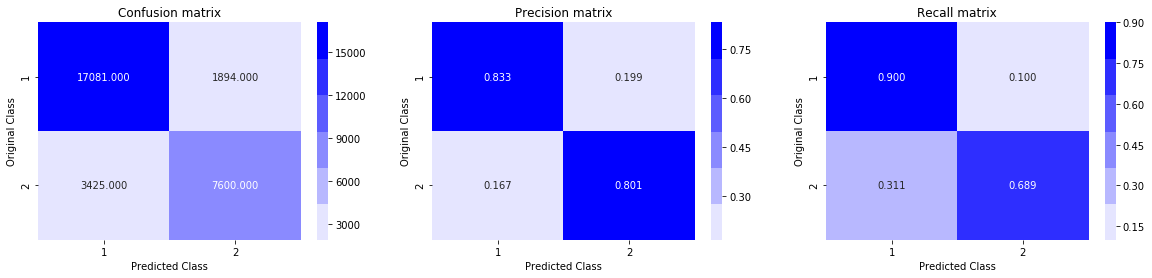

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


In [300]:
import pandas as pd
final_features = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

In [301]:
print(final_features.isnull().sum())

id                       0
qid1                     0
qid2                     0
question1               14
question2                6
is_duplicate             0
cwc_min                  0
cwc_max                  0
csc_min                  0
csc_max                  0
ctc_min                  0
ctc_max                  0
last_word_eq             0
first_word_eq            0
abs_len_diff             0
mean_len                 0
token_set_ratio          0
token_sort_ratio         0
fuzz_ratio               0
fuzz_partial_ratio       0
longest_substr_ratio     0
dtype: int64


In [302]:
final_features = final_features.dropna()

In [303]:
final_features.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [304]:
final_features = final_features.sample(frac=1)

In [305]:
final_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404270 entries, 56546 to 261861
Data columns (total 21 columns):
id                      404270 non-null int64
qid1                    404270 non-null int64
qid2                    404270 non-null int64
question1               404270 non-null object
question2               404270 non-null object
is_duplicate            404270 non-null int64
cwc_min                 404270 non-null float64
cwc_max                 404270 non-null float64
csc_min                 404270 non-null float64
csc_max                 404270 non-null float64
ctc_min                 404270 non-null float64
ctc_max                 404270 non-null float64
last_word_eq            404270 non-null float64
first_word_eq           404270 non-null float64
abs_len_diff            404270 non-null float64
mean_len                404270 non-null float64
token_set_ratio         404270 non-null int64
token_sort_ratio        404270 non-null int64
fuzz_ratio              404270 non-

In [306]:
#Taking only first 1 lakh observations
final_features = final_features.iloc[:100001,:]

In [307]:
final_features.shape

(100001, 21)

In [308]:
#delete before submission
#final_features.to_csv('final_features_1_lac')

In [309]:
#delete before submission
#import pandas as pd
#final_features = pd.read_csv('final_features_1_lac')

In [310]:
final_features['question1'] = final_features['question1'].astype(str)
final_features['question2'] = final_features['question2'].astype(str)
#df.id.apply(str)

#final_features['question1'] = final_features.question1.apply(str)
#final_features['question2'] = final_features.question2.apply(str)

In [311]:
print(final_features['question1'])

56546                          what is black history month 
70453               how does world war 2 started and ended 
28324     spoiler  does the name valak appears as separa...
31269     has ancient history been scientifically tested...
284001    what are the best ways to improve my english b...
                                ...                        
334781                         do actors actually have sex 
370972          what does trump own victory mean for india 
127534         what are your new year resolutions for 2017 
357443    how do i conceive a baby boy artificially in i...
187487                  what is a good diet to lose weight 
Name: question1, Length: 100001, dtype: object


In [312]:
final_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100001 entries, 56546 to 187487
Data columns (total 21 columns):
id                      100001 non-null int64
qid1                    100001 non-null int64
qid2                    100001 non-null int64
question1               100001 non-null object
question2               100001 non-null object
is_duplicate            100001 non-null int64
cwc_min                 100001 non-null float64
cwc_max                 100001 non-null float64
csc_min                 100001 non-null float64
csc_max                 100001 non-null float64
ctc_min                 100001 non-null float64
ctc_max                 100001 non-null float64
last_word_eq            100001 non-null float64
first_word_eq           100001 non-null float64
abs_len_diff            100001 non-null float64
mean_len                100001 non-null float64
token_set_ratio         100001 non-null int64
token_sort_ratio        100001 non-null int64
fuzz_ratio              100001 non-

In [313]:
#Test-tran split
from sklearn.model_selection import train_test_split
y = final_features['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(final_features, y, stratify=y, test_size=0.3)

In [314]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000, 21)
(70000,)
(30001, 21)
(30001,)


In [315]:
final_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100001 entries, 56546 to 187487
Data columns (total 21 columns):
id                      100001 non-null int64
qid1                    100001 non-null int64
qid2                    100001 non-null int64
question1               100001 non-null object
question2               100001 non-null object
is_duplicate            100001 non-null int64
cwc_min                 100001 non-null float64
cwc_max                 100001 non-null float64
csc_min                 100001 non-null float64
csc_max                 100001 non-null float64
ctc_min                 100001 non-null float64
ctc_max                 100001 non-null float64
last_word_eq            100001 non-null float64
first_word_eq           100001 non-null float64
abs_len_diff            100001 non-null float64
mean_len                100001 non-null float64
token_set_ratio         100001 non-null int64
token_sort_ratio        100001 non-null int64
fuzz_ratio              100001 non-

In [316]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf(train, ds, feature):
    #train = np.array()
    vectorizer = TfidfVectorizer(min_df=10)
    vectorizer.fit(train[feature])
    feature_tfidf = vectorizer.transform(ds[feature].values)
    print("Shape of matrix after one hot encodig ",feature_tfidf.shape)
    return feature_tfidf

In [317]:
ques_1_tfidf_train = tfidf(X_train ,X_train, 'question1')
ques_1_tfidf_test = tfidf(X_train ,X_test, 'question1')

ques_2_tfidf_train = tfidf(X_train ,X_train, 'question2')
ques_2_tfidf_test = tfidf(X_train ,X_test, 'question2')


Shape of matrix after one hot encodig  (70000, 5230)
Shape of matrix after one hot encodig  (30001, 5230)
Shape of matrix after one hot encodig  (70000, 5178)
Shape of matrix after one hot encodig  (30001, 5178)


In [318]:
print(ques_1_tfidf_train)

  (0, 5001)	0.4980007868921107
  (0, 2819)	0.41733913886015467
  (0, 2739)	0.45937049876031943
  (0, 2401)	0.46368396723562977
  (0, 2346)	0.14989841834580298
  (0, 2257)	0.13872111387566757
  (0, 779)	0.1757414929537338
  (0, 396)	0.28142677062521865
  (1, 5120)	0.3506690556264517
  (1, 4443)	0.5771886226173633
  (1, 1032)	0.7374852590710702
  (2, 5112)	0.2647645740390179
  (2, 4699)	0.10736288127131646
  (2, 3271)	0.2964129824380395
  (2, 3252)	0.4611722225546642
  (2, 2879)	0.37168276109181686
  (2, 2361)	0.23727972814558726
  (2, 2346)	0.13728243358476463
  (2, 2009)	0.22363800660124988
  (2, 1385)	0.387138788851838
  (2, 1157)	0.3776974522303275
  (2, 779)	0.1609504629918856
  (2, 579)	0.1899616524558817
  (3, 3105)	0.48354772443892863
  (3, 2843)	0.3200486609060007
  :	:
  (69998, 4758)	0.15280125200757924
  (69998, 4177)	0.2917976635038299
  (69998, 4168)	0.2850651275100846
  (69998, 4163)	0.2178909796356354
  (69998, 3564)	0.26733082663161234
  (69998, 3274)	0.21539261603173412

In [319]:
print(ques_2_tfidf_train)

  (0, 5161)	0.19357751844954518
  (0, 3978)	0.46072581875691737
  (0, 2805)	0.44673461469297676
  (0, 2726)	0.4417196993902006
  (0, 2396)	0.44293354378310523
  (0, 769)	0.1712071422699268
  (0, 1)	0.360651279929709
  (1, 5059)	0.1575641323921793
  (1, 4635)	0.16031728145865115
  (1, 2480)	0.16884475978853167
  (1, 2337)	0.20259355580794763
  (1, 1016)	0.744430103309359
  (1, 591)	0.570739023523948
  (2, 5070)	0.2449309038546024
  (2, 4635)	0.12362280047631899
  (2, 3229)	0.34065828078530286
  (2, 3223)	0.22578160010069268
  (2, 2868)	0.4225609108270739
  (2, 2356)	0.26821950885897017
  (2, 2337)	0.15622260120406004
  (2, 1369)	0.43972336039048426
  (2, 1145)	0.4629345705403907
  (2, 578)	0.21366823097215884
  (2, 366)	0.1716879952353363
  (3, 3074)	0.32263373164291137
  :	:
  (69998, 5135)	0.13355509441669688
  (69998, 4888)	0.1519341684096341
  (69998, 4698)	0.21920621375629307
  (69998, 4635)	0.05851049322199574
  (69998, 4326)	0.26359810772294867
  (69998, 4192)	0.2673684074047195


In [320]:
from sklearn.preprocessing import StandardScaler
def standardize_numerical(train, ds, feature):
    feature_scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
    feature_scalar.fit(train[feature].values.reshape(-1,1)) # finding the mean and standard deviation of this data
    #print(f"{feature}_standardized : Mean : {feature_scalar.mean_[0]}, Standard deviation : {np.sqrt(feature_scalar.var_[0])}")
    #Now standardize the data with above maen and variance.
    feature_standardized = feature_scalar.transform(ds[feature].values.reshape(-1, 1))
    print(feature,": ","Mean: ", feature_standardized.mean(),"Standard deviation:", feature_standardized.std())
    #print(f"{feature}_standardized : Mean : {feature_standardized.mean_[0]}, Standard deviation : {np.sqrt(feature_standardized.var_[0])}")
    return feature_standardized

In [321]:
cwc_min_standardized_train = standardize_numerical(X_train, X_train, 'cwc_min')
cwc_min_standardized_test = standardize_numerical(X_train, X_test, 'cwc_min')
cwc_max_standardized_train = standardize_numerical(X_train, X_train, 'cwc_max')
cwc_max_standardized_test = standardize_numerical(X_train, X_test, 'cwc_max')
csc_min_standardized_train = standardize_numerical(X_train, X_train, 'csc_min')
csc_min_standardized_test = standardize_numerical(X_train, X_test, 'csc_min')
csc_max_standardized_train = standardize_numerical(X_train, X_train, 'csc_max')
csc_max_standardized_test = standardize_numerical(X_train, X_test, 'csc_max')
ctc_min_standardized_train = standardize_numerical(X_train, X_train, 'ctc_min')
ctc_min_standardized_test = standardize_numerical(X_train, X_test, 'ctc_min')
ctc_max_standardized_train = standardize_numerical(X_train, X_train, 'ctc_max')
ctc_max_standardized_test = standardize_numerical(X_train, X_test, 'ctc_max')

last_word_eq_standardized_train = standardize_numerical(X_train, X_train, 'last_word_eq')
last_word_eq_standardized_test = standardize_numerical(X_train, X_test, 'last_word_eq')
first_word_eq_standardized_train = standardize_numerical(X_train, X_train, 'first_word_eq')
first_word_eq_standardized_test = standardize_numerical(X_train, X_test, 'first_word_eq')
abs_len_diff_standardized_train = standardize_numerical(X_train, X_train, 'abs_len_diff')
abs_len_diff_standardized_test = standardize_numerical(X_train, X_test, 'abs_len_diff')
mean_len_standardized_train = standardize_numerical(X_train, X_train, 'mean_len')
mean_len_standardized_test = standardize_numerical(X_train, X_test, 'mean_len')
token_set_ratio_standardized_train = standardize_numerical(X_train, X_train, 'token_set_ratio')
token_set_ratio_standardized_test = standardize_numerical(X_train, X_test, 'token_set_ratio')
token_sort_ratio_standardized_train = standardize_numerical(X_train, X_train, 'token_sort_ratio')
token_sort_ratio_standardized_test = standardize_numerical(X_train, X_test, 'token_sort_ratio')

fuzz_ratio_standardized_train = standardize_numerical(X_train, X_train, 'fuzz_ratio')
fuzz_ratio_standardized_test = standardize_numerical(X_train, X_test, 'fuzz_ratio')
fuzz_partial_ratio_standardized_train = standardize_numerical(X_train, X_train, 'fuzz_partial_ratio')
fuzz_partial_ratio_standardized_test = standardize_numerical(X_train, X_test, 'fuzz_partial_ratio')
longest_substr_ratio_standardized_train = standardize_numerical(X_train, X_train, 'longest_substr_ratio')
longest_substr_ratio_standardized_test = standardize_numerical(X_train, X_test, 'longest_substr_ratio')

cwc_min :  Mean:  5.910700500472947e-16 Standard deviation: 1.0
cwc_min :  Mean:  0.0056167635251436485 Standard deviation: 0.9993201143865862
cwc_max :  Mean:  2.2676463881258055e-16 Standard deviation: 0.9999999999999999
cwc_max :  Mean:  0.008338645767540627 Standard deviation: 1.0012009505067625
csc_min :  Mean:  -1.0333321500054028e-16 Standard deviation: 1.0
csc_min :  Mean:  0.004454236354195081 Standard deviation: 1.0001773476967546
csc_max :  Mean:  4.263256414560601e-18 Standard deviation: 0.9999999999999998
csc_max :  Mean:  0.008079336198218174 Standard deviation: 1.0023671234178007
ctc_min :  Mean:  1.1977720402813119e-16 Standard deviation: 1.0
ctc_min :  Mean:  0.0063287943955938055 Standard deviation: 1.0004069349289946
ctc_max :  Mean:  1.1165671561944432e-17 Standard deviation: 1.0
ctc_max :  Mean:  0.008084793110442875 Standard deviation: 1.003291009612882
last_word_eq :  Mean:  1.096265935172726e-17 Standard deviation: 1.0
last_word_eq :  Mean:  -0.00162498086429177

In [322]:
from scipy.sparse import hstack
set_tfidf_X_train = hstack((ques_1_tfidf_train, ques_2_tfidf_train, cwc_min_standardized_train, cwc_max_standardized_train, csc_min_standardized_train, csc_max_standardized_train, ctc_min_standardized_train, ctc_max_standardized_train, last_word_eq_standardized_train, first_word_eq_standardized_train, abs_len_diff_standardized_train, mean_len_standardized_train, token_set_ratio_standardized_train, token_sort_ratio_standardized_train, fuzz_ratio_standardized_train, fuzz_partial_ratio_standardized_train, longest_substr_ratio_standardized_train))
set_tfidf_X_test = hstack((ques_1_tfidf_test, ques_2_tfidf_test, cwc_min_standardized_test, cwc_max_standardized_test, csc_min_standardized_test, csc_max_standardized_test, ctc_min_standardized_test, ctc_max_standardized_test, last_word_eq_standardized_test, first_word_eq_standardized_test, abs_len_diff_standardized_test, mean_len_standardized_test, token_set_ratio_standardized_test, token_sort_ratio_standardized_test, fuzz_ratio_standardized_test, fuzz_partial_ratio_standardized_test, longest_substr_ratio_standardized_test))


In [323]:
print(set_tfidf_X_train.shape)
print(set_tfidf_X_test.shape)

(70000, 10423)
(30001, 10423)


In [324]:
print(y_train.shape)
print(y_test.shape)

(70000,)
(30001,)


In [325]:
print("Number of data points in train data :",set_tfidf_X_train.shape)
print("Number of data points in train data :",y_train.shape)
print("Number of data points in test data :",set_tfidf_X_test.shape)
print("Number of data points in train data :",y_test.shape)

Number of data points in train data : (70000, 10423)
Number of data points in train data : (70000,)
Number of data points in test data : (30001, 10423)
Number of data points in train data : (30001,)


<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

In [326]:
#Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
print("alpha:", alpha)
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(set_tfidf_X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(set_tfidf_X_train, y_train)
    predict_y = sig_clf.predict_proba(set_tfidf_X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



alpha: [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]
For values of alpha =  1e-05 The log loss is: 0.44477000839469694
For values of alpha =  0.0001 The log loss is: 0.4512070461996015
For values of alpha =  0.001 The log loss is: 0.48475128858950656
For values of alpha =  0.01 The log loss is: 0.522928895005209
For values of alpha =  0.1 The log loss is: 0.542103832390581
For values of alpha =  1 The log loss is: 0.5621886577924184
For values of alpha =  10 The log loss is: 0.5704093451317483


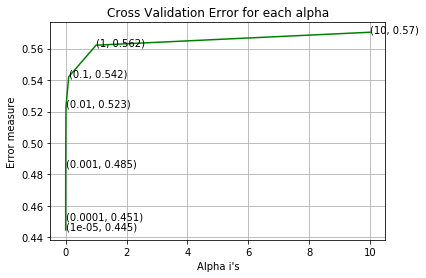

For values of best alpha =  1e-05 The train log loss is: 0.384869649589107
For values of best alpha =  1e-05 The test log loss is: 0.44477000839469694
Total number of data points : 30001


In [327]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(set_tfidf_X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(set_tfidf_X_train, y_train)

predict_y = sig_clf.predict_proba(set_tfidf_X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(set_tfidf_X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))


In [328]:
predict_y.shape

(30001, 2)

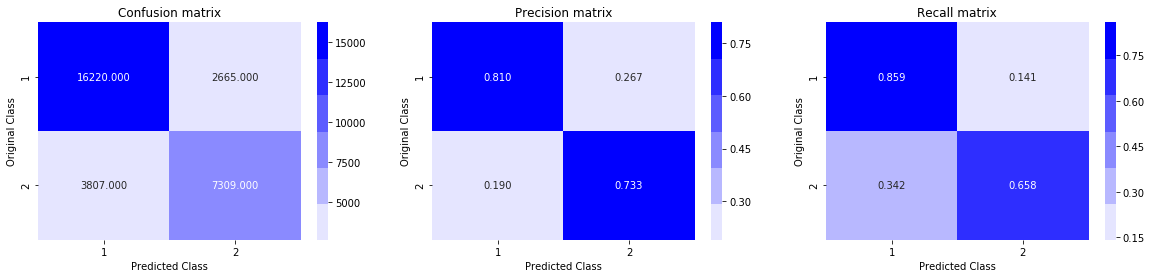

In [329]:
plot_confusion_matrix(y_test, predicted_y)

In [330]:
score = accuracy_score(y_test, predicted_y)
print(score)

0.7842738575380821


<h2> Linear SVM with hyperparameter tuning </h2>

In [331]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(set_tfidf_X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(set_tfidf_X_train, y_train)
    predict_y = sig_clf.predict_proba(set_tfidf_X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    

For values of alpha =  1e-05 The log loss is: 0.46939823211766213
For values of alpha =  0.0001 The log loss is: 0.4614274082892482
For values of alpha =  0.001 The log loss is: 0.5149300764097607
For values of alpha =  0.01 The log loss is: 0.611646609470402
For values of alpha =  0.1 The log loss is: 0.570799057024838
For values of alpha =  1 The log loss is: 0.6592323744064514
For values of alpha =  10 The log loss is: 0.6592323744064517


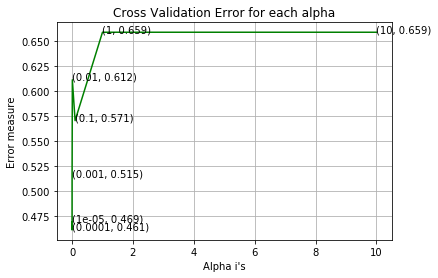

For values of best alpha =  0.0001 The train log loss is: 0.44860282464863577
For values of best alpha =  0.0001 The test log loss is: 0.4614274082892482
Total number of data points : 30001


In [332]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(set_tfidf_X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(set_tfidf_X_train, y_train)

predict_y = sig_clf.predict_proba(set_tfidf_X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(set_tfidf_X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))


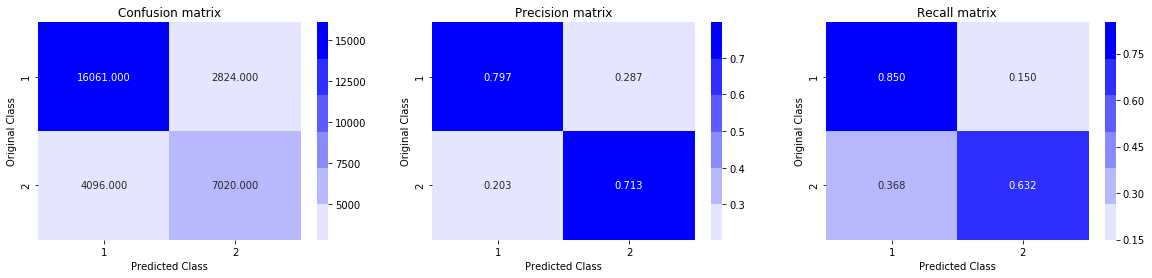

In [333]:
plot_confusion_matrix(y_test, predicted_y)

In [334]:
score = accuracy_score(y_test, predicted_y)
print(score)

0.7693410219659345


<h2> XGBOOST </h2>

Objective:  2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

__Just for comparison we will use both Grid search and randomized grid search__

<h3>XGBOOST with grid search</h3>

In [335]:
import numpy as np
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold 
from scipy.stats import randint, uniform

#reproducibility
seed=32
np.random.seed(seed)

params_grid = {
    
    'max_depth': [1, 2, 3],
    'n_estimators': [5, 10, 25, 50],
    'learning_rate': np.linspace(1e-16, 1, 3)
}

params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

bst_grid = GridSearchCV(
    estimator = XGBClassifier(**params_fixed, seed=seed),
    param_grid = params_grid,
    scoring='accuracy',
    return_train_score=True
)

In [336]:
bst_grid.fit(set_tfidf_X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=32, silent=1,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': array([1.e-16, 5.e-01, 1.e+00]),
                         'max_depth': [1, 2, 3],
                         'n_estimators': [5

In [337]:
bst_grid.cv_results_


{'mean_fit_time': array([0.87756713, 1.29579751, 2.09845177, 3.42079107, 1.14654374,
        1.66702445, 3.32548515, 5.89773409, 1.39931218, 2.1788973 ,
        4.58680789, 8.46130045, 0.9008104 , 1.17529027, 2.10794608,
        5.08460681, 1.58373213, 2.4865454 , 3.27209012, 6.90263597,
        1.57988477, 2.35331988, 5.29881692, 9.73943798, 1.04163869,
        1.30539012, 2.37217522, 3.89200362, 1.29338074, 1.80510322,
        3.4471341 , 6.99240073, 1.52551572, 2.32818413, 4.77603285,
        8.85394049]),
 'std_fit_time': array([0.01350635, 0.12801409, 0.10440679, 0.20671268, 0.01901617,
        0.04068919, 0.10746525, 0.21405605, 0.02229838, 0.03965908,
        0.10128712, 0.21148027, 0.0173698 , 0.04606581, 0.11918481,
        0.04699368, 0.10505273, 0.40031486, 0.07447793, 0.52737181,
        0.05215574, 0.03716519, 0.43650267, 0.39091315, 0.01455811,
        0.05879334, 0.13697675, 0.32503434, 0.01125752, 0.05744326,
        0.03314589, 0.24986558, 0.02506034, 0.03420696, 0.054

In [339]:
print("Best accuracy obtained: {0}".format(bst_grid.best_score_))
print("Parameters:")
for key, value in bst_grid.best_params_.items():
    print("\t{}: {}".format(key, value))

Best accuracy obtained: 0.7744285714285715
Parameters:
	learning_rate: 0.5
	max_depth: 3
	n_estimators: 50


In [341]:
best_params_dist_grid_1 = {
    'max_depth': 3,
    'learning_rate': 0.5,
    'n_estimator': 50
}

In [342]:
import xgboost as xgb

d_train = xgb.DMatrix(set_tfidf_X_train, label=y_train)
d_test = xgb.DMatrix(set_tfidf_X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(best_params_dist_grid_1, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(set_tfidf_X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-7))

[0]	train-rmse:0.442867	valid-rmse:0.444014
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[10]	train-rmse:0.398405	valid-rmse:0.40167
[20]	train-rmse:0.390571	valid-rmse:0.395053
[30]	train-rmse:0.38427	valid-rmse:0.390366
[40]	train-rmse:0.379992	valid-rmse:0.387443
[50]	train-rmse:0.376371	valid-rmse:0.385515
[60]	train-rmse:0.372946	valid-rmse:0.382951
[70]	train-rmse:0.370846	valid-rmse:0.382088
[80]	train-rmse:0.368318	valid-rmse:0.380758
[90]	train-rmse:0.366158	valid-rmse:0.379519
[100]	train-rmse:0.364304	valid-rmse:0.378751
[110]	train-rmse:0.362597	valid-rmse:0.37801
[120]	train-rmse:0.361038	valid-rmse:0.37763
[130]	train-rmse:0.359399	valid-rmse:0.376867
[140]	train-rmse:0.357929	valid-rmse:0.37649
[150]	train-rmse:0.355442	valid-rmse:0.375253
[160]	train-rmse:0.35413	valid-rmse:0.374739
[170]	train-rmse:0.352257	valid-rmse:0.3742
[180]	train-rmse:0.351103	valid-rmse:0.374041


In [343]:
predicted_y = np.copy(predict_y)
for i in range(0, len(predicted_y)):
    if predicted_y[i] >=0.50:
        predicted_y[i]=1
    else:
        predicted_y[i]=0

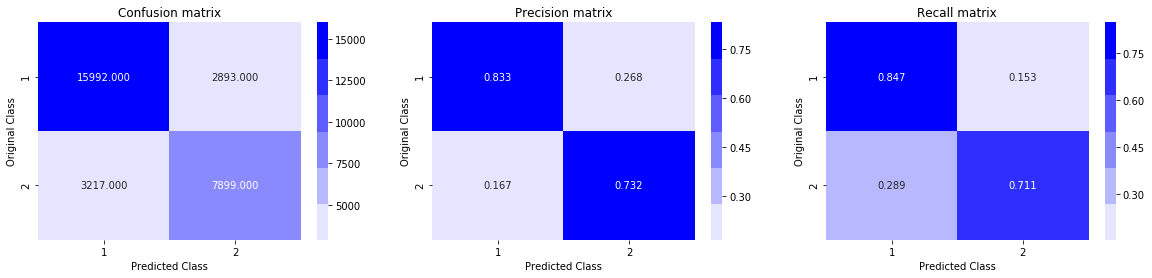

In [344]:
plot_confusion_matrix(y_test, predicted_y)

In [346]:
score = accuracy_score(y_test, predicted_y)
print(score)

0.7963401219959335


<h3>XGBOOST with Randomized grid search</h3>

In [347]:
#source: https://www.youtube.com/watch?v=R5eJgjn9bnw&t=75s
params_dist_grid = {
    'max_depth': [1,2,3,4],
    'gamma': [0, 0.5, 1],
    'n_estimator': randint(1,1001),
    'learning_rate': uniform(),
    'subsample': uniform(),
    'colspace_bytree': uniform()
}

In [348]:
rs_grid = RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=seed),
    param_distributions=params_dist_grid,
    n_iter=10,
    scoring='accuracy',
    random_state=seed
)

In [349]:
rs_grid.fit(set_tfidf_X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_al...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc8b86d4128>,
                                        'max_depth': [1, 2, 3, 4],
                          

In [350]:
rs_grid.cv_results_

{'mean_fit_time': array([16.2314237 , 15.67134619,  6.63343469,  5.88311346,  6.47691035,
         6.48008506, 19.34861366, 15.43031462,  5.95145019,  9.94911671]),
 'std_fit_time': array([0.28596358, 0.20734712, 0.01413574, 0.07097684, 0.00110451,
        0.04735628, 0.52016179, 0.50705794, 0.08488206, 0.19305239]),
 'mean_score_time': array([0.31161181, 0.31682142, 0.28520528, 0.31732821, 0.27561736,
        0.27588129, 0.36665885, 0.32075278, 0.29287378, 0.29219214]),
 'std_score_time': array([0.00961178, 0.00362712, 0.01006951, 0.01613011, 0.00673359,
        0.00395357, 0.0336806 , 0.0207076 , 0.0159833 , 0.01187071]),
 'param_colspace_bytree': masked_array(data=[0.8588892672930397, 0.7317397804275537,
                    0.5965534361232749, 0.8482212912402136,
                    0.5617918399347968, 0.46096040588241327,
                    0.1212429267214542, 0.16650012302602912,
                    0.06665020954014078, 0.29854124528692305],
              mask=[False, False, Fals

In [351]:
rs_grid.best_params_

{'colspace_bytree': 0.8588892672930397,
 'gamma': 0.5,
 'learning_rate': 0.4210379835600314,
 'max_depth': 3,
 'n_estimator': 89,
 'subsample': 0.7539957518627464}

In [352]:
rs_grid.estimator

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=32, silent=1,
              subsample=1, verbosity=1)

__Now we apply the best searched parameter by the RandomizedSearchCV in the classifier__

In [353]:
best_params_dist_grid = {
    'max_depth': 3,
    'gamma': 0.5,
    'n_estimator': 89,
    'learning_rate': 0.4210379835600314,
    'subsample': 0.7539957518627464,
    'colspace_bytree': 0.8588892672930397
}

In [354]:
import xgboost as xgb

d_train = xgb.DMatrix(set_tfidf_X_train, label=y_train)
d_test = xgb.DMatrix(set_tfidf_X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(best_params_dist_grid, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(set_tfidf_X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-7))

[0]	train-rmse:0.449676	valid-rmse:0.450667
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[10]	train-rmse:0.399805	valid-rmse:0.402971
[20]	train-rmse:0.391939	valid-rmse:0.395902
[30]	train-rmse:0.386493	valid-rmse:0.391653
[40]	train-rmse:0.381579	valid-rmse:0.387832
[50]	train-rmse:0.377943	valid-rmse:0.385636
[60]	train-rmse:0.375142	valid-rmse:0.383837
[70]	train-rmse:0.372742	valid-rmse:0.382628
[80]	train-rmse:0.370201	valid-rmse:0.380958
[90]	train-rmse:0.3683	valid-rmse:0.380047
[100]	train-rmse:0.366367	valid-rmse:0.378918
[110]	train-rmse:0.364771	valid-rmse:0.378394
[120]	train-rmse:0.363145	valid-rmse:0.377768
[130]	train-rmse:0.361562	valid-rmse:0.377475
[140]	train-rmse:0.360051	valid-rmse:0.376653
[150]	train-rmse:0.358636	valid-rmse:0.376101
[160]	train-rmse:0.357422	valid-rmse:0.375868
[170]	train-rmse:0.356139	valid-rmse:0.375619
[180]	train-rmse:0.354964	valid-rmse:0.3

In [355]:
predicted_y = np.copy(predict_y)
for i in range(0, len(predicted_y)):
    if predicted_y[i] >=0.50:
        predicted_y[i]=1
    else:
        predicted_y[i]=0
        

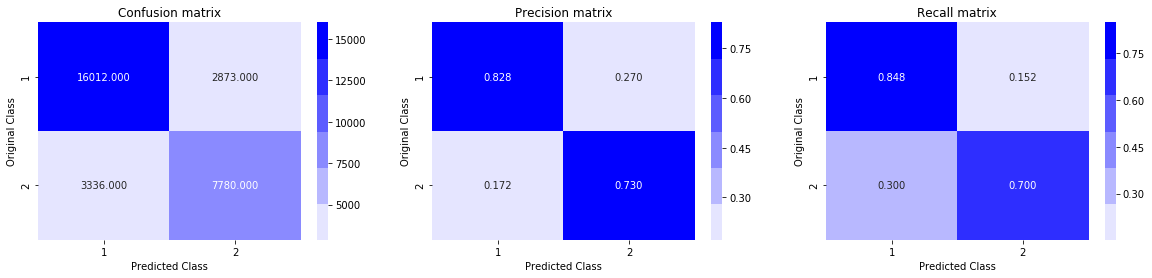

In [356]:
plot_confusion_matrix(y_test, predicted_y)

In [357]:
score = accuracy_score(y_test, predicted_y)
print(score)

0.7930402319922669


In [362]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["ML Algorithm", "Train loss", "Test loss", "Accuracy"]

x.add_row(["Logistic Regression", 0.3779, 0.4381, 0.7842])
x.add_row(["Linear SVM"         , 0.4486, 0.4614, 0.7693])
x.add_row(["XGBOOST Grid Search",       0.3604, 0.4794, 0.7963])
x.add_row(["XGBOOST Randomized Search", 0.3476, 0.4359, 0.7930])



__Steps to solve the problem:__

__1. Load the dataset and remove all the rows containing(NAN). In this dataset only three rows contained NAN, so were removed and Choose 1 lakh samples__

__2. split the dataset into test and train sets. Maintain 30:70 ratio__

__3. Data Precprocessing: vectorise(TFIDF) questions, standardize all numerical variables. For train data, variable should fit and transform on train data. But for test data variable should be fit on train data and transform on test data__

__4. Stack all variables together into one set- Train_set and Test_set__

__5. Use- Logistic regression, Linear SVM, XGBOOST with Grid search and with randomized search. Notedown the train loss and accuracy in pretty table__

<h3>Observations</h3>

In [361]:
print(x)

+---------------------------+------------+-----------+----------+
|        ML Algorithm       | Train loss | Test loss | Accuracy |
+---------------------------+------------+-----------+----------+
|    Logistic Regression    |   0.3779   |   0.4381  |  0.7842  |
|         Linear SVM        |   0.4486   |   0.4614  |  0.7693  |
|    XGBOOST Grid Search    |   0.3604   |   0.4794  |  0.7963  |
| XGBOOST Randomized Search |   0.3476   |   0.4359  |  0.793   |
+---------------------------+------------+-----------+----------+


__1. All the test losses and train losses seems very close to each other. none of the model seem to be overfit or underfit.__

__2. XGBOOST Randomized Search gives the higest accuracy. Also if we see the precision and recall matrices XGBOOST Randomized Search outperforms in comparison to other models__